In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00484_2.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00541_4.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00305_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00052_2.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00218_2.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00353_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00013_3.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00093_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00559_4.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00518_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00554_0.jpg
/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data

# Introduction
Dans le cadre d'une étude sur la santé des plantes en utilisant la vision par ordinateur, nous avons décidé de mettre en place un modèle de segmentation d'images en utilisant l'architecture U-Net.

## Importation des librairies

In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from PIL import Image
import random

##  Importation des donées

In [3]:
image_dir = '/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images'
mask_dir = '/kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/masks'

##  Prétraitement et Chargement des Images et des Masques pour la segmentation

In [4]:
def load_images_and_masks(image_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = img_to_array(load_img(img_path, target_size=img_size)) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=img_size, color_mode="grayscale")) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

images, masks = load_images_and_masks(image_dir, mask_dir)

## Visualisation des images  

Image: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00000_0.jpg


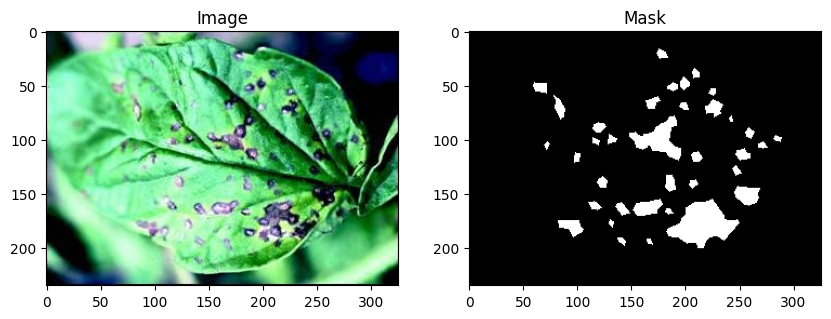

Image: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00000_1.jpg


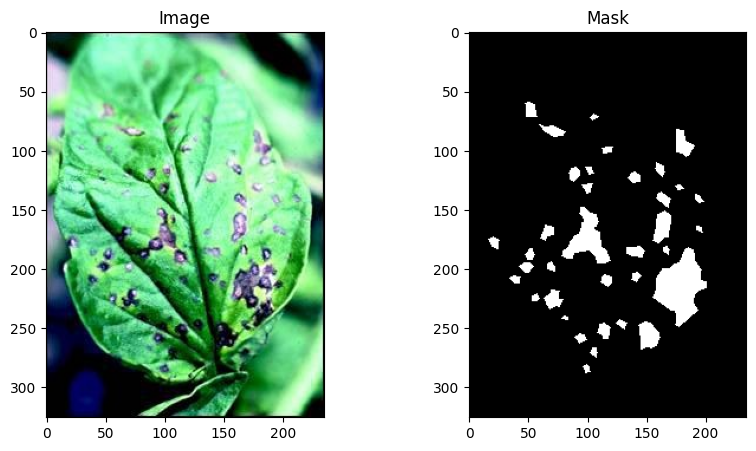

Image: /kaggle/input/leaf-disease-segmentation-dataset/aug_data/aug_data/images/00000_2.jpg


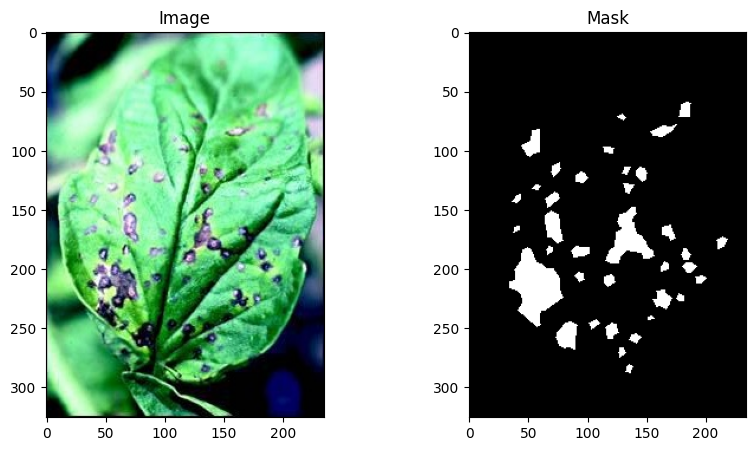

In [5]:
def show_images(image_dir, mask_dir, loops=3):
    image_files = sorted(os.listdir(image_dir))
    for i in range(loops):
        img_path = os.path.join(image_dir, image_files[i])
        mask_path = os.path.join(mask_dir, os.path.splitext(image_files[i])[0] + ".png")

        img = Image.open(img_path)
        mask = Image.open(mask_path)

        print(f"Image: {img_path}")
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Image")
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        
        plt.show()

show_images(image_dir, mask_dir, loops=3)

## Création des ensembles de test, de validation et d'entrainement

In [6]:
train_images, valtest_images, train_masks, valtest_masks = train_test_split(images, masks, test_size=0.4, random_state=42)
val_images, test_images, val_masks, test_masks = train_test_split(valtest_images, valtest_masks, test_size=0.5, random_state=42)

# Vérifier les dimensions des ensembles
print(f"Train set: {train_images.shape}, {train_masks.shape}")
print(f"Validation set: {val_images.shape}, {val_masks.shape}")
print(f"Test set: {test_images.shape}, {test_masks.shape}")

Train set: (1764, 256, 256, 3), (1764, 256, 256, 1)
Validation set: (588, 256, 256, 3), (588, 256, 256, 1)
Test set: (588, 256, 256, 3), (588, 256, 256, 1)


## Formation du modèle 

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import load_model


def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    
    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

unet = unet_model()

## Mise en place de checkpoint pour garder le meilleur modèle

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('unet_best_model.keras', monitor='val_loss', save_best_only=True)

## Entrainement du modèle et visualiisation des courbes d'accuracy et de loss

Epoch 1/50


I0000 00:00:1729250851.656152     267 service.cc:145] XLA service 0x7c5f5008d210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729250851.656248     267 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729250851.656255     267 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729250879.457506     267 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 ━━━━━━━━━━━━━━━━━━━━ 80s 455ms/step - accuracy: 0.8007 - loss: 0.1683 - val_accuracy: 0.8370 - val_loss: 0.0977
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 30s 273ms/step - accuracy: 0.8423 - loss: 0.0947 - val_accuracy: 0.8370 - val_loss: 0.1108
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 31s 279ms/step - accuracy: 0.8385 - loss: 0.0979 - val_accuracy: 0.8370 - val_loss: 0.0954
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 31s 276ms/step - accuracy: 0.8370 - loss: 0.0964 - val_accuracy: 0.8370 - val_loss: 0.0935
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 31s 276ms/step - accuracy: 0.8428 - loss: 0.0911 - val_accuracy: 0.8370 - val_loss: 0.1009
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 31s 276ms/step - accuracy: 0.8369 - loss: 0.0943 - val_accuracy: 0.8370 - val_loss: 0.0940
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 31s 276ms/step - accuracy: 0.8320 - loss: 0.0988 - val_accuracy: 0.8370 - val_loss: 0.0935
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 31s 276ms/step - accuracy: 0.8454 - loss: 0.0900 - val

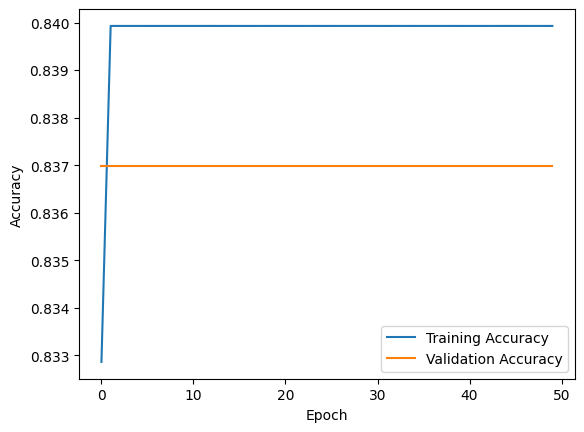

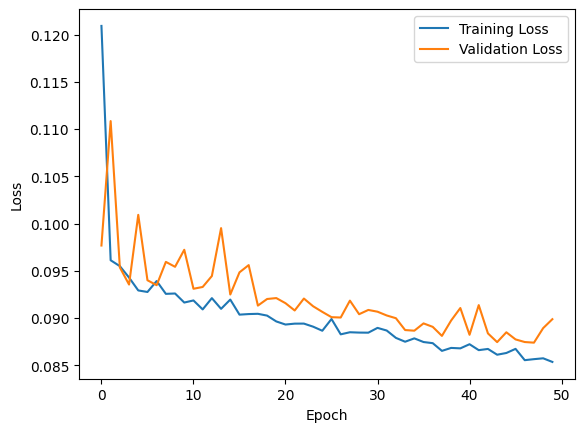

In [9]:
history = unet.fit(train_images, train_masks, epochs=50, batch_size=16, validation_data=(val_images, val_masks), 
                   callbacks=[early_stop, model_checkpoint])

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test sur les images de test

In [10]:

test_loss, test_acc = unet.evaluate(test_images, test_masks)


19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.8338 - loss: 0.0880


In [11]:
unetacc = history.history['accuracy'][-1]
print(f"Last Training Accuracy: {unetacc}")

Last Training Accuracy: 0.8399279117584229


## Visualisation des prédictions

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step


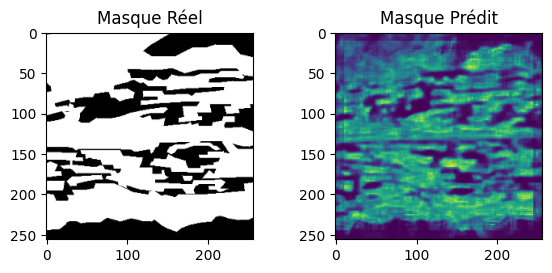

In [12]:
import matplotlib.pyplot as plt

# Supposons que 'y' soit tes masques réels et 'result' soit tes prédictions
y = val_masks  # ou test_masks selon l'ensemble que tu veux visualiser
result = unet.predict(val_images)  # ou test_images pour tester tes prédictions

# Ajuste la taille de l'image si nécessaire
image_size = 256

# Comparer les images réelles avec leurs masques prédits
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Afficher la première image et son masque prédit
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0] * 255, (image_size, image_size)), cmap="gray")
ax.set_title("Masque Réel")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0] * 255, (image_size, image_size)), cmap="viridis")
ax.set_title("Masque Prédit")

plt.show()


### Sauvegarde du modèle 

In [13]:
unet.save('/kaggle/working/model_unet_best.keras')
